In [20]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from dataset import build_dataloaders
from bilstm import BiLSTMAttentionClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttentionClassifier(
    pc_vocab=9,
    acc_vocab=10,
    oct_vocab=7,
    dur_vocab=46,
    meas_vocab=4,
    emb_dim=128,
    lstm_hidden=64,
    num_classes=12,
    dropout=0.3
)
model.to(device)
checkpoint = torch.load("best_model.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print("Loaded best model from epoch:", checkpoint["epoch"])

_, _, _, test_loader = build_dataloaders(
    "vocab.pkl", "dataset.pkl", batch_size=8)

Loaded best model from epoch: 17


In [3]:
@torch.no_grad()
def get_predictions(model, dataloader, device):
    model.eval()

    all_preds = []
    all_labels = []
    all_f_names = []
    all_attn_weights = []
    all_true_lengths = []
    all_pcs = []
    all_accs = []
    all_meas = []

    for batch in dataloader:
        f_names = batch["f_names"]
        lengths = batch["lengths"]
        batch["accs"]
        batch["meas"]
        batch = {k: v.to(device) for k, v in batch.items() if k != "f_names"}
        logits, attn_weights = model(batch)
        labels = batch["labels"]
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_f_names.append(f_names)
        all_attn_weights.extend(attn_weights.cpu().numpy())
        all_true_lengths.append(lengths.cpu().numpy())
        all_pcs.extend(batch["pcs"].cpu().numpy())
        all_accs.extend(batch["accs"].cpu().numpy())
        all_meas.extend(batch["meas"].cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_f_names = np.concatenate(all_f_names)
    all_true_lengths = np.concatenate(all_true_lengths)

    return (
        all_labels,
        all_preds,
        all_f_names,
        all_attn_weights,
        all_true_lengths,
        all_pcs,
        all_accs,
        all_meas
    )

In [4]:
(
    all_labels,
    all_preds,
    all_f_names,
    all_attn_weights,
    all_true_lengths,
    all_pcs,
    all_accs,
    all_meas
) = get_predictions(model, test_loader, device)

In [5]:
print(
    all_labels.shape,
    all_preds.shape,
    all_f_names.shape,
    len(all_attn_weights),
    all_true_lengths.shape,
    len(all_pcs),
    len(all_accs),
    len(all_meas)
)

(175,) (175,) (175,) 175 (175,) 175 175 175


In [6]:
makam_vocab = {"hicaz": 0,
               "nihavent": 1,
               "ussak": 2,
               "rast": 3,
               "huzzam": 4,
               "segah": 5,
               "huseyni": 6,
               "mahur": 7,
               "hicazkar": 8,
               "kurdilihicazkar": 9,
               "muhayyer": 10,
               "saba": 11}
makam_names = [k for k in makam_vocab]

pc_vocab = {
    "PAD": 0, "Rest": 1,
    "G": 2, "A": 3, "B": 4, "C": 5, "D": 6, "E": 7, "F": 8
}
pc_vocab_inv = {v: k for k, v in pc_vocab.items()}

acc_vocab = {"PAD": 0, "": 1,
             "#1": 2, "#2": 3, "#3": 4, "#4": 5, "#5": 6, "#6": 7, "#7": 8, "#8": 9}
acc_vocab_inv = {v: k for k, v in acc_vocab.items()}

In [7]:
def evaluate_classification(y_true, y_pred, makam_names):
    results = {}

    # Overall accuracy
    results["accuracy"] = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 per class
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        average=None
    )

    # Macro & weighted
    results["macro_f1"] = np.mean(f1)
    results["weighted_f1"] = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="weighted"
    )[2]

    # Confusion matrix
    results["confusion_matrix"] = confusion_matrix(y_true, y_pred)

    print(classification_report(
        y_true,
        y_pred,
        target_names=makam_names,
        digits=4
    ))
    return results

In [8]:
results = evaluate_classification(all_labels, all_preds, makam_names)

                 precision    recall  f1-score   support

          hicaz     1.0000    1.0000    1.0000        27
       nihavent     1.0000    1.0000    1.0000        18
          ussak     0.7500    0.8571    0.8000        14
           rast     0.9231    1.0000    0.9600        12
         huzzam     1.0000    1.0000    1.0000        17
          segah     1.0000    1.0000    1.0000        22
        huseyni     0.6000    0.5455    0.5714        11
          mahur     1.0000    0.8947    0.9444        19
       hicazkar     1.0000    1.0000    1.0000        11
kurdilihicazkar     1.0000    1.0000    1.0000         6
       muhayyer     0.8889    0.8889    0.8889         9
           saba     1.0000    1.0000    1.0000         9

       accuracy                         0.9429       175
      macro avg     0.9302    0.9322    0.9304       175
   weighted avg     0.9439    0.9429    0.9426       175



In [9]:
results["confusion_matrix"]

array([[27,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 22,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  6,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  1,  0,  0,  1, 17,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9]])

In [10]:
def plot_confusion_matrix(
    cm,
    class_names,
    title="Normalized Confusion Matrix"
):
    # Normalize row-wise
    cm = cm.astype(float)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(7, 6))
    sns.set_theme(style="white", font="Times")

    ax = sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Proportion"},
        annot_kws={"size": 10}
    )

    ax.set_xlabel("Predicted Makam", fontsize=12)
    ax.set_ylabel("True Makam", fontsize=12)
    ax.figure.axes[-1].yaxis.label.set_size(12)
    ax.set_title(title, fontsize=12, pad=12)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig("cm.pdf", bbox_inches="tight", pad_inches=0.05)
    plt.show()

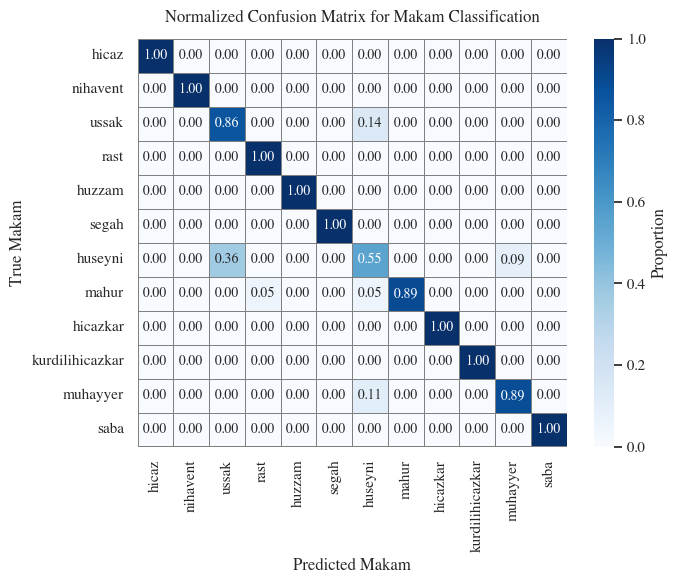

In [11]:
plot_confusion_matrix(
    results["confusion_matrix"],
    makam_names,
    title="Normalized Confusion Matrix for Makam Classification"
)

In [29]:
def plot_attention_over_time(attn, title="Attention over Notes"):
    plt.figure(figsize=(6, 3))
    plt.plot(attn, linewidth=2)
    plt.xlabel("Note Index", fontname="Times", fontsize=12)
    plt.ylabel("Attention Weight", fontname="Times", fontsize=12)
    plt.title(title, fontname="Times", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig("attn_time.pdf", bbox_inches="tight", pad_inches=0.05)
    plt.show()

In [34]:
def plot_attention_with_pitch(attn, pcs, pc_vocab_inv):
    pitches = [pc_vocab_inv[p] for p in pcs]

    plt.figure(figsize=(24, 3))
    plt.bar(range(len(attn)), attn)
    plt.xticks(
        range(len(pitches)),
        pitches,
        rotation=90,
        fontsize=6,
        fontname="Times"
    )
    plt.xlabel("Note Index", fontname="Times", fontsize=12)
    plt.ylabel("Attention Weight", fontname="Times", fontsize=12)
    plt.title("Attention Aligned with Pitch Classes",
              fontname="Times", fontsize=12)
    plt.tight_layout()
    plt.savefig("pitch_attn.pdf", bbox_inches="tight", pad_inches=0.05)
    plt.show()

In [37]:
def plot_attention_with_measures(attn, meas):
    plt.figure(figsize=(12, 3))
    plt.plot(attn, linewidth=2)

    for i, m in enumerate(meas):
        if m == 3:  # measure end {'PAD': 0, 'start': 1, 'middle': 2, 'end': 3}
            plt.axvline(i, color="red", alpha=0.2)

    plt.xlabel("Note Index", fontname="Times", fontsize=12)
    plt.ylabel("Attention Weight", fontname="Times", fontsize=12)
    plt.title("Attention with Measure Boundaries",
              fontname="Times", fontsize=12)
    plt.tight_layout()
    plt.savefig("meas_attn.pdf", bbox_inches="tight", pad_inches=0.05)
    plt.show()

In [15]:
def combine_pitch_pc_acc(pc_idx, acc_idx, pc_vocab_inv, acc_vocab_inv):
    pc = pc_vocab_inv.get(pc_idx, "UNK")
    acc_name = acc_vocab_inv.get(acc_idx, "natural")

    if pc == "PAD":
        return "PAD"
    if pc == "Rest":
        return "Rest"

    return f"{pc}{acc_name}"

In [35]:
def plot_attention_with_combined_pitch(
    attn,
    pcs,
    accs,
    pc_vocab_inv,
    acc_vocab_inv
):
    pitch_labels = [
        combine_pitch_pc_acc(p, a, pc_vocab_inv, acc_vocab_inv)
        for p, a in zip(pcs, accs)
    ]

    plt.figure(figsize=(24, 3))
    plt.bar(range(len(attn)), attn)
    plt.xticks(
        range(len(pitch_labels)),
        pitch_labels,
        rotation=90,
        fontsize=6,
        fontname="Times"
    )
    plt.xlabel("Note Index", fontname="Times", fontsize=12)
    plt.ylabel("Attention Weight", fontname="Times", fontsize=12)
    plt.title("Attention Aligned with Combined Pitch Classes",
              fontname="Times", fontsize=12)
    plt.tight_layout()
    plt.savefig("comb_pitch_attn.pdf", bbox_inches="tight", pad_inches=0.05)
    plt.show()

In [61]:
def aggregate_attention_by_pitch(attn, pitch_ids):
    """
    attn: (L,)
    pcs:  (L,) pitch class ids
    """
    agg = defaultdict(float)
    for a, p in zip(attn, pitch_ids):
        agg[p] += a
    return agg


def aggregate_attention_by_pitch_acc(attn, pcs, accs):
    """
    attn: (L,)
    pcs:  (L,) pitch class ids
    accs: (L,) accidental ids
    """
    agg = defaultdict(float)

    for a, pc, acc in zip(attn, pcs, accs):
        if pc == 0:  # PAD
            continue
        agg[(pc, acc)] += float(a)

    return agg

In [90]:
def get_makam_pieces(makam_id, labels, preds, correct=True):
    """
    {'hicaz': 0,
    'nihavent': 1,
    'ussak': 2,
    'rast': 3,
    'huzzam': 4,
    'segah': 5,
    'huseyni': 6,
    'mahur': 7,
    'hicazkar': 8,
    'kurdilihicazkar': 9,
    'muhayyer': 10,
    'saba': 11}
    """
    res = []
    for i, (y_hat, y) in enumerate(zip(preds, labels)):
        if y != makam_id:
            continue
        if correct and y_hat == y:
            res.append(i)
        if not correct and y_hat != y:
            res.append(i)
    return np.array(res)

In [114]:
correct_hicaz_idx = get_makam_pieces(0, all_labels, all_preds)
len(correct_hicaz_idx)

27

In [105]:
i = 54  # index of the piece in the test set

# all_labels, all_preds, all_f_names, all_attn_weights, all_true_lengths

true_len = all_true_lengths[i]

attn_piece = all_attn_weights[i][:true_len]
pcs_piece = all_pcs[i][:true_len]
accs_piece = all_accs[i][:true_len]
meas_piece = all_meas[i][:true_len]
print(makam_names[all_labels[i]], all_f_names[i], true_len)
attn_piece.shape == pcs_piece.shape == (true_len,)
agg = aggregate_attention_by_pitch_acc(attn_piece, pcs_piece, accs_piece)

hicaz hicaz--sarki--nimsofyan--cok_yasa--muhlis_sabahaddin_ezgi.txt 226


In [106]:
def plot_agg_attention_by_pitch(agg):
    labels = []
    values = []

    for (pc, acc), val in sorted(agg.items(), key=lambda x: -x[1]):
        pc_name = pc_vocab_inv[pc]
        acc_name = acc_vocab_inv[acc]
        labels.append(f"{pc_name}{acc_name}")
        values.append(val)

    plt.figure(figsize=(6, 3))
    plt.bar(labels, values)
    plt.xticks(rotation=45, fontname="Times", fontsize=10)
    plt.ylabel("Total Attention", fontname="Times", fontsize=12)
    plt.title("Aggregated Attention by Pitch + Accidental",
              fontname="Times", fontsize=12)
    plt.tight_layout()
    plt.show()

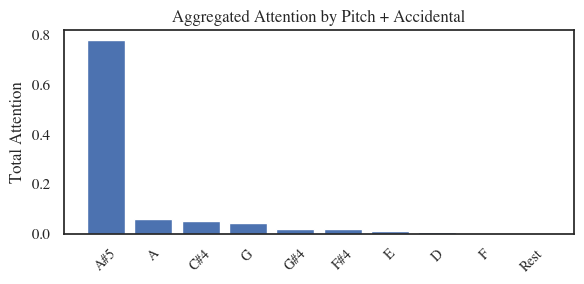

In [107]:
plot_agg_attention_by_pitch(agg)

In [116]:
def aggregate_attention_for_makam(
        makam_idx,
        all_pcs,
        all_accs,
        all_true_lengths,
        all_labels,
        all_attn_weights
):
    num_pieces = len(all_pcs)
    makam_agg = defaultdict(float)
    piece_count = 0

    for i in range(num_pieces):
        if all_labels[i] != makam_idx:
            continue

        true_len = all_true_lengths[i]
        attn_piece = all_attn_weights[i][:true_len]
        pcs_piece = all_pcs[i][:true_len]
        accs_piece = all_accs[i][:true_len]

        piece_agg = aggregate_attention_by_pitch_acc(
            attn_piece, pcs_piece, accs_piece
        )

        for k, v in piece_agg.items():
            makam_agg[k] += v

        piece_count += 1

    return makam_agg, piece_count


def normalize_attention(agg_dict):
    total = sum(agg_dict.values())
    return {k: v / total for k, v in agg_dict.items()}

In [121]:
makam_vocab

{'hicaz': 0,
 'nihavent': 1,
 'ussak': 2,
 'rast': 3,
 'huzzam': 4,
 'segah': 5,
 'huseyni': 6,
 'mahur': 7,
 'hicazkar': 8,
 'kurdilihicazkar': 9,
 'muhayyer': 10,
 'saba': 11}

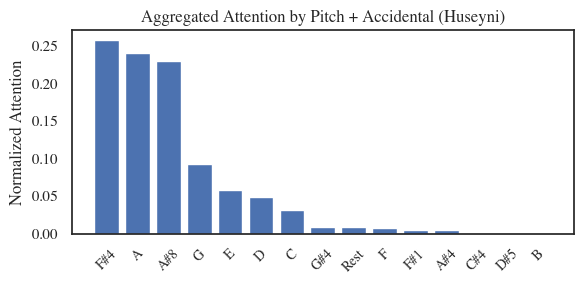

In [130]:
makam = "huseyni"

makam_agg, piece_count = aggregate_attention_for_makam(
    makam_vocab[makam],
    all_pcs,
    all_accs,
    all_true_lengths,
    all_labels,
    all_attn_weights
)

makam_agg = normalize_attention(makam_agg)
labels = []
values = []

for (pc, acc), val in sorted(
    makam_agg.items(), key=lambda x: -x[1]
):
    labels.append(f"{pc_vocab_inv[pc]}{acc_vocab_inv[acc]}")
    values.append(val)


plt.figure(figsize=(6, 3))
plt.bar(labels, values)
plt.xticks(rotation=45, fontname="Times", fontsize=10)
plt.title(
    f"Aggregated Attention by Pitch + Accidental "
    f"({makam.capitalize()})",
    fontname="Times", fontsize=12
)
plt.ylabel("Normalized Attention", fontname="Times", fontsize=12)
plt.tight_layout()
plt.show()

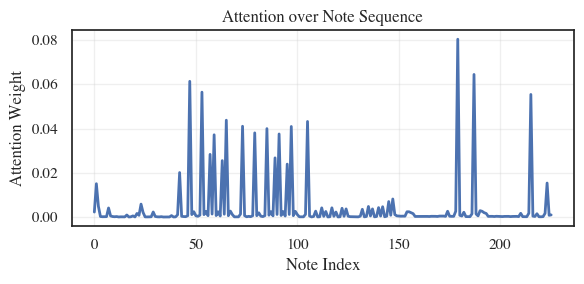

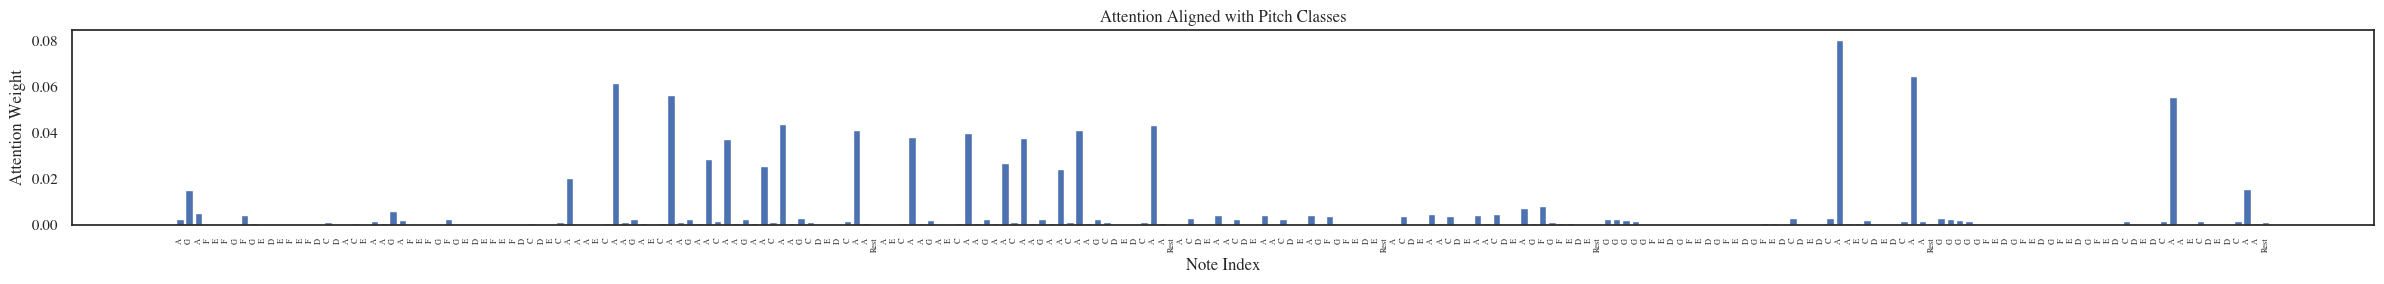

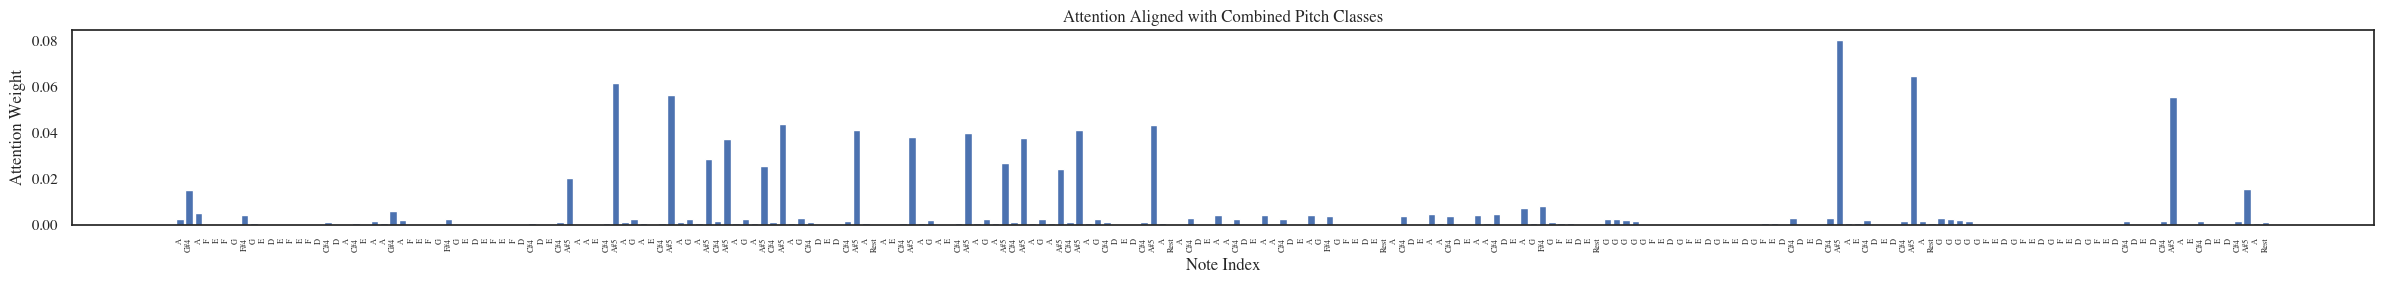

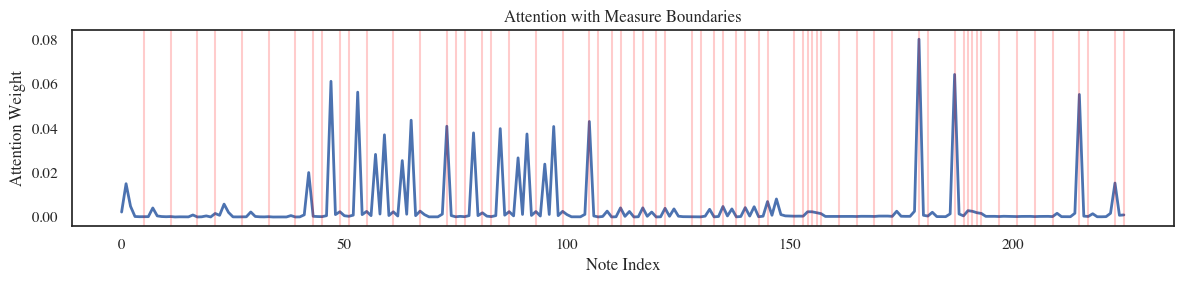

In [108]:
plot_attention_over_time(
    attn_piece,
    title="Attention over Note Sequence"
)
plot_attention_with_pitch(
    attn_piece,
    pcs_piece,
    pc_vocab_inv
)
plot_attention_with_combined_pitch(
    attn_piece,
    pcs_piece,
    accs_piece,
    pc_vocab_inv,
    acc_vocab_inv
)
plot_attention_with_measures(attn_piece, meas_piece)